In [1]:
import lecroy
import rigol
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (11,8)
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

from sigproc_kit import *
import time

import apply_network
import json
from my_utils import *


LECROY,WR620ZI,LCRY2805N57162,8.5.1
Rigol Technologies,DG4202,DG4E212801262,00.01.14
Found Numpy. WIll be used for storing data


In [2]:
clear_data_dir()

In [3]:
fine = True

In [15]:
##################################################
##                init PASTTREC                 ##
##################################################

import pasttrec_ctrl as ptc

channel = 7
my_baseline = 6

ptc.init_board("0001",1,15,4,127)
#ptc.init_board("0001",1,20,2,127) # alternative setting, pkt 20, gain 2, does the model still hold?
#ptc.init_board("0001",1,10,1,127) # alternative setting
ptc.set_baseline("0001",1,channel,my_baseline) 
# zero V baseline for my channel relative to thr=0 - > scan said baseline at 5



In [5]:
##################################################
##              program RIGOL AWG               ##
##################################################


awg_samples = 2**12
awg_period = 500e-9
awg_time = np.linspace(0,awg_period,awg_samples)

injection_resistor = 32.8e3

#test_curr = -50e-6

#test_amp = test_curr*injection_resistor



#test_i = test_curr*(awg_time>50e-9)*(awg_time<350e-9)

#sigma = 1e-9
#test_i  = test_curr*gauss(awg_time,mu=100e-9,sigma=sigma)*sigma

test_charge = 0.5e-12
test_i = - test_charge * gauss(awg_time,mu=100e-9,sigma=2.5e-9)

test_curr = np.max(abs(test_i))
test_amp  = test_curr * injection_resistor

#test_i =  test_curr*(awg_time>50e-9)*(awg_time<55e-9)

y1 = test_i * injection_resistor
y2 = y1

print("test current   = {:e} A".format(test_curr))
print("test amplitude = {:f} V".format(test_amp))

rigol.set_waveform(1,awg_time,y1)
rigol.set_waveform(2,awg_time,y2)

pickle_this(test_i,"test_i")


test current   = 7.978846e-05 A
test amplitude = 2.617061 V
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/test_i.pickle


saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/000.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/000.pickle


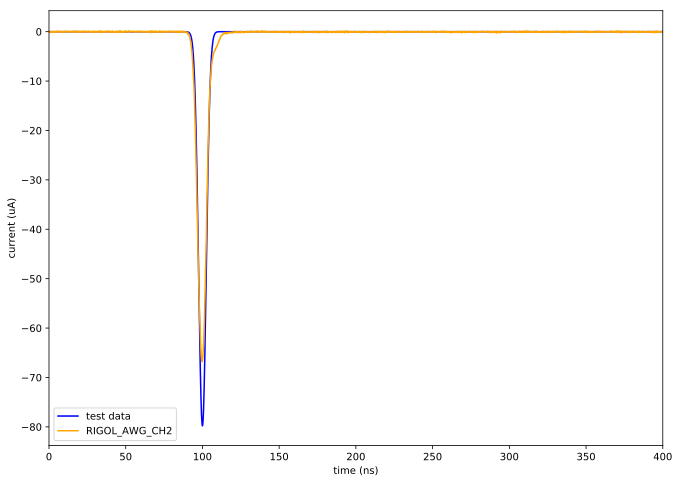

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/001.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/001.pickle


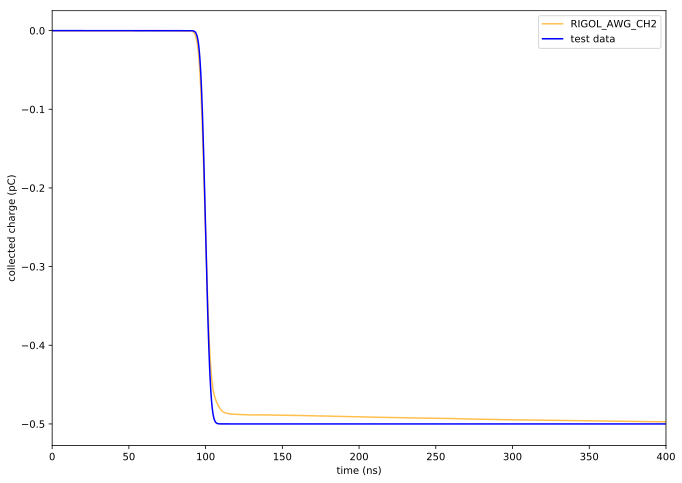

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/meas_i.pickle


In [6]:
##################################################
##           configure LeCroy Scope             ##
##################################################

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.rcParams["figure.figsize"] = (11,8)

lecroy.clear_all()
lecroy.set_tdiv(100e-9)

# access scope sources by labels
s = {
    "RIGOL_AWG_CH2"    :"C1", # set to 50R DC
    "PASTTREC_LVDS"    :"C4", # use LeCroy ZS1500 differential probe
    "PASTTREC_analog"  :"C3"  # set to 50R DC
}

# set vertical amplifications and offsets
lecroy.set_vdiv(              s["PASTTREC_LVDS"],200e-3)
lecroy.set_voffset(           s["PASTTREC_LVDS"],-1200e-3 )

lecroy.set_vdiv(              s["RIGOL_AWG_CH2"],abs(test_amp/4.*1.2))

lecroy.set_vdiv(              s["PASTTREC_analog"],200e-3*test_charge*1e12*8)
lecroy.set_voffset(           s["PASTTREC_analog"],-700e-3 )


# access scope measurements by labels
m = {
    "PASTTREC_t1"  : "p3",
    "PASTTREC_tot" : "p4"
}

# TDC measurements for differential probe at 100R terminated PASTTREC LVDS output
lecroy.setup_measurement(m["PASTTREC_t1"] ,s["PASTTREC_LVDS"],"delay")
lecroy.setup_measurement(m["PASTTREC_tot"],s["PASTTREC_LVDS"],"widthn")


# access scope trigger channels by labels

t = {
    "RIGOL_AWG_SYNC1" : "D9",
    "RIGOL_AWG_SYNC2" : "D10"
}

##################################################
##             measure AWG Waveform             ##
##################################################

lecroy.set_trig_source(t["RIGOL_AWG_SYNC2"])

time, wfm = lecroy.capture_waveforms([
    s["RIGOL_AWG_CH2"]
], average = (fine==True)*100 + (fine==False)*1  )

time_ns     = time*1e9
awg_time_ns = awg_time*1e9


meas_i = wfm[s["RIGOL_AWG_CH2"]] / injection_resistor

meas_i = remove_baseline(meas_i)

plt.plot(awg_time_ns, test_i *1e6,"b" ,label="test data")
plt.plot(time_ns,     meas_i *1e6,"orange" ,label="RIGOL_AWG_CH2")


plt.legend()
plt.xlabel("time (ns)")
plt.ylabel("current (uA)")
plt.xlim(0,400)
show(plt)

##################################################
##          see if charge is conserved          ##
##################################################

plt.plot(time_ns,     integrate_dt(time,     meas_i)*1e12 ,"orange",alpha=0.7 ,label="RIGOL_AWG_CH2")
plt.plot(awg_time_ns, integrate_dt(awg_time, test_i)*1e12 ,"b" ,label="test data")

plt.legend()
plt.xlabel("time (ns)")
plt.ylabel("collected charge (pC)")
plt.xlim(0,400)
show(plt)

pickle_this(meas_i,"meas_i")

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/002.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/002.pickle


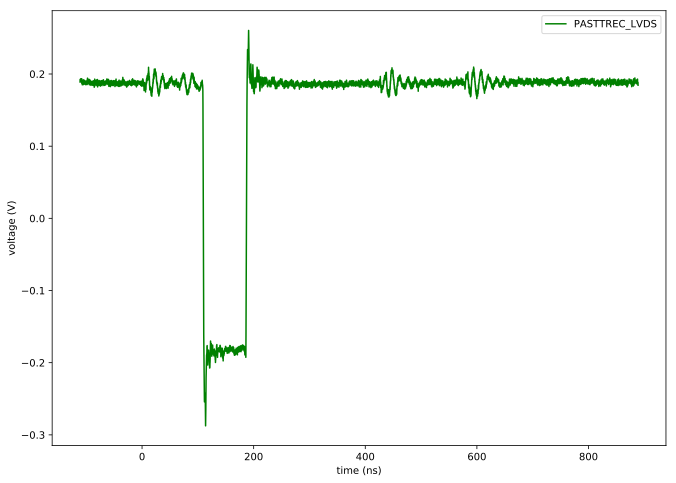

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/003.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/003.pickle


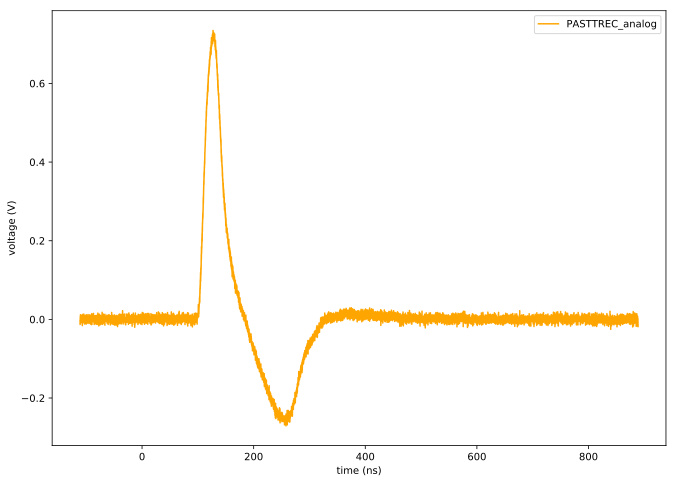

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/004.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/004.pickle


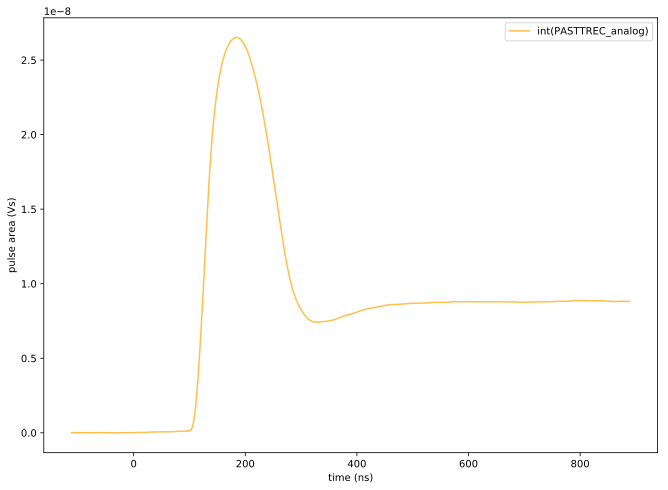

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/time_ns.pickle
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/pt_ana.pickle


In [7]:
##################################################
##      capture ana waveform and LVDS out       ##
##################################################

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.rcParams["figure.figsize"] = (11,8)

lecroy.set_trig_source(t["RIGOL_AWG_SYNC1"])


ptc.set_threshold("0001",1,0,16) # tdc, conn, chip thresh


lecroy.set_vdiv(              s["PASTTREC_analog"],200e-3*test_charge*1e12*8)
lecroy.set_voffset(           s["PASTTREC_analog"],-700e-3 )

time, wfm = lecroy.capture_waveforms([
    s["PASTTREC_LVDS"],
    s["PASTTREC_analog"]
  ],
    average = (fine==True)*10 + (fine==False)*1
)

time_ns = time*1e9 -11

# remove analog signal baseline, calculate bl from the first 10% of the sample
pt_ana = wfm[s["PASTTREC_analog"]]
pt_ana = remove_baseline(pt_ana,fraction=0.08)

plt.plot(time_ns,wfm[s["PASTTREC_LVDS"]] ,"g" ,label="PASTTREC_LVDS")
plt.legend()
plt.xlabel("time (ns)")
plt.ylabel("voltage (V)")
show(plt)

plt.plot(time_ns,pt_ana,"orange",label="PASTTREC_analog")
plt.legend()
plt.xlabel("time (ns)")
plt.ylabel("voltage (V)")
show(plt)

##################################################
##                 Output integral              ##
##################################################

plt.plot(time_ns,     integrate_dt(time,     pt_ana) ,"orange",alpha=0.7 ,label="int(PASTTREC_analog)")


plt.legend()
plt.xlabel("time (ns)")
plt.ylabel("pulse area (Vs)")
#plt.xlim(0,400)
show(plt)

pickle_this(time_ns,"time_ns")
pickle_this(pt_ana,"pt_ana")

processing spice circuit pasttrec_model.asc
input data did not change, reading existing .raw file
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/005.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/005.pickle


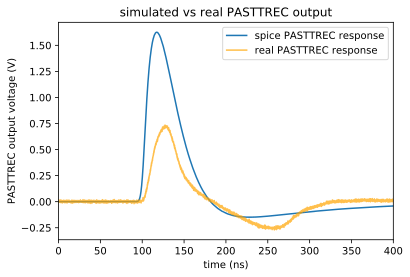

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/006.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/006.pickle


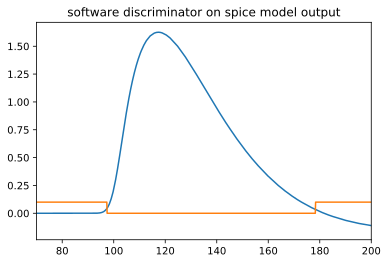

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/007.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/007.pickle


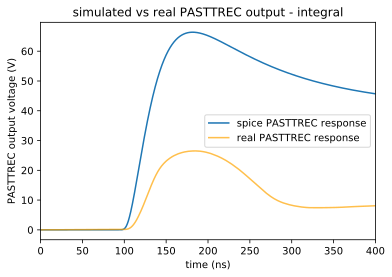

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/awg_time.pickle
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/normalized_pt_vout.pickle


In [8]:
##################################################
##         call SPICE, calculate FEE IR         ##
##################################################

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.rcParams["figure.figsize"] = (6,4)

fee_spice_conf = "pasttrec_pkt15ns.fee.json"
fee_spice_conf_json = get_file_json(fee_spice_conf)
fee_configuration = fee_spice_conf_json["configuration"]
fee_model         = fee_spice_conf_json["model"]
  

dummy, vout_fee = apply_network.apply_network(
        fee_model,
        awg_time,
        test_i,
        params=fee_configuration
        )

normalized_pt_vout = vout_fee/test_charge

plt.title("simulated vs real PASTTREC output")

plt.plot(awg_time*1e9, -vout_fee ,label="spice PASTTREC response")
plt.plot(time_ns,pt_ana,"orange",alpha=0.7,label="real PASTTREC response")

plt.legend()
plt.xlabel("time (ns)")
plt.ylabel("PASTTREC output voltage (V)")
plt.xlim(0,400)
#plt.xlim(90,150)
show(plt)

############# software discriminator ##############


plt.title("software discriminator on spice model output")
plt.plot(awg_time*1e9, -vout_fee ,label="spice PASTTREC response")

soft_discr_out,t1,tot = discriminate(awg_time*1e9,  -vout_fee, 30e-3,8.4e-3,4.2e-3) 

plt.plot(awg_time*1e9, 0.1*soft_discr_out,label="spice PASTTREC after discriminator thresh 30 mV, hyst 8.4 mV")
plt.xlim(0,400)
plt.xlim(70,200)
show(plt)



plt.title("simulated vs real PASTTREC output - integral")

plt.plot(awg_time*1e9, -integrate_dt(awg_time*1e9,vout_fee) ,label="spice PASTTREC response")
plt.plot(time_ns,integrate_dt(time_ns,pt_ana),"orange",alpha=0.7,label="real PASTTREC response")

plt.legend()
plt.xlabel("time (ns)")
plt.ylabel("PASTTREC output voltage (V)")
plt.xlim(0,400)
#plt.xlim(90,150)
show(plt)

pickle_this(awg_time,"awg_time")
pickle_this(normalized_pt_vout,"normalized_pt_vout")

In [9]:
##################################################
##     systematic charge scan, ana out          ##
##################################################

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.rcParams["figure.figsize"] = (11,8)

ana_mem=[]

charge_classes=10

for log_test_charge in np.linspace(np.log(20e-15),np.log(900e-15),charge_classes):
#for test_charge in [10e-15, 20e-15, 50e-15, 100e-15, 0.2e-12, 0.4e-12,0.8e-12, 0.9e-12]:
  test_charge = np.exp(log_test_charge)
  test_i = - test_charge * gauss(awg_time,mu=100e-9,sigma=2.5e-9)

  test_curr = np.max(abs(test_i))
  test_amp  = test_curr * injection_resistor

  y1 = test_i * injection_resistor

  print("test charge       = {:f} fC".format(test_charge*1e15))
  print("max(test current) = {:f} uA".format(test_curr*1e6))
  print("test amplitude    = {:f} V".format(test_amp))

  rigol.set_waveform(1,awg_time,y1)


  lecroy.set_vdiv(              s["PASTTREC_analog"],200e-3*test_charge*1e12*10)
  lecroy.set_voffset(           s["PASTTREC_analog"],-700e-3 )

  time, wfm = lecroy.capture_waveforms([
      s["PASTTREC_analog"]
    ],
      average= (fine==True)*100 + (fine==False)*1
  )

  time_ns = time*1e9

  # remove analog signal baseline, calculate bl from the first 10% of the sample
  pt_ana = wfm[s["PASTTREC_analog"]]
  pt_ana = remove_baseline(pt_ana,fraction=0.08)


  # store for later access
  ana_mem += [{"charge":test_charge, "time":time.tolist(), "voltage":pt_ana.tolist()}]

  pt_ana /= abs(np.max(pt_ana))

pickle_this(ana_mem,"ana_mem")

test charge       = 20.000000 fC
max(test current) = 3.191538 uA
test amplitude    = 0.104682 V
test charge       = 30.529541 fC
max(test current) = 4.871810 uA
test amplitude    = 0.159795 V
test charge       = 46.602644 fC
max(test current) = 7.436706 uA
test amplitude    = 0.243924 V
test charge       = 71.137866 fC
max(test current) = 11.351961 uA
test amplitude    = 0.372344 V
test charge       = 108.590320 fC
max(test current) = 17.328508 uA
test amplitude    = 0.568375 V
test charge       = 165.760631 fC
max(test current) = 26.451570 uA
test amplitude    = 0.867611 V
test charge       = 253.029800 fC
max(test current) = 40.377714 uA
test amplitude    = 1.324389 V
test charge       = 386.244182 fC
max(test current) = 61.635654 uA
test amplitude    = 2.021649 V
test charge       = 589.592880 fC
max(test current) = 94.085411 uA
test amplitude    = 3.086001 V
test charge       = 900.000000 fC
max(test current) = 143.619221 uA
test amplitude    = 4.710710 V
saving to /workdir/jupyter

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/008.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/008.pickle


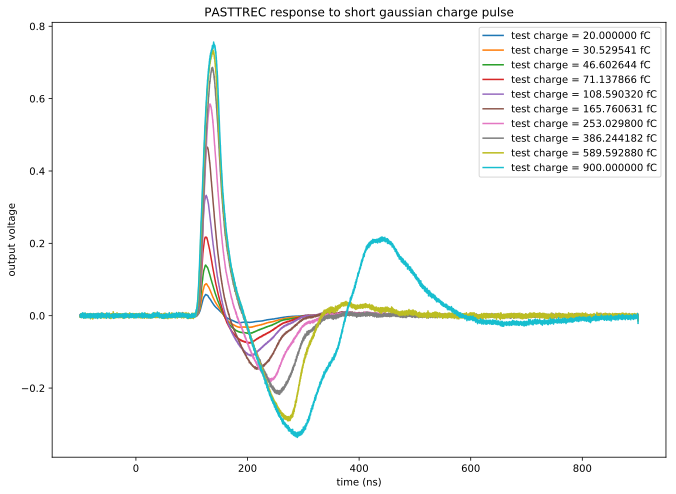

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/009.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/009.pickle


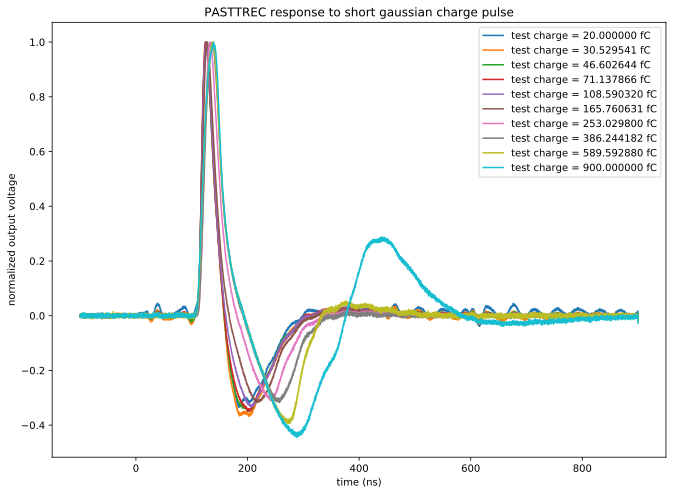

In [10]:
##################################################
##     access analog waveforms individually     ##
##################################################


for i in range(0,len(ana_mem)):
  plt.plot(np.array(ana_mem[i]["time"])*1e9,ana_mem[i]["voltage"],
           label="test charge = {:f} fC".format(ana_mem[i]["charge"]*1e15))
plt.legend()
plt.xlabel("time (ns)")
plt.ylabel("output voltage")
plt.title("PASTTREC response to short gaussian charge pulse")
show(plt)

for i in range(0,len(ana_mem)):

  plt.plot(np.array(ana_mem[i]["time"])*1e9,np.array(ana_mem[i]["voltage"])/np.max(abs(np.array(ana_mem[i]["voltage"]))),
           label="test charge = {:f} fC".format(ana_mem[i]["charge"]*1e15))


plt.legend()
plt.xlabel("time (ns)")
plt.ylabel("normalized output voltage")
plt.title("PASTTREC response to short gaussian charge pulse")
show(plt)


saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/010.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/010.pickle


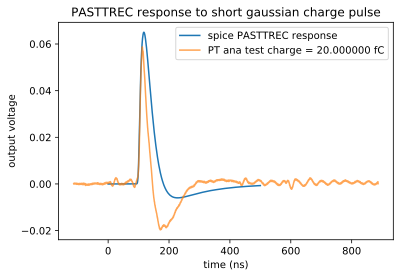

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/011.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/011.pickle


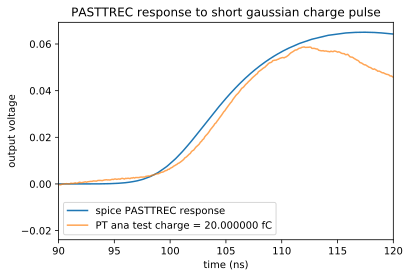

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/012.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/012.pickle


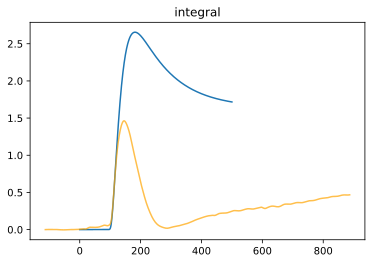

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/013.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/013.pickle


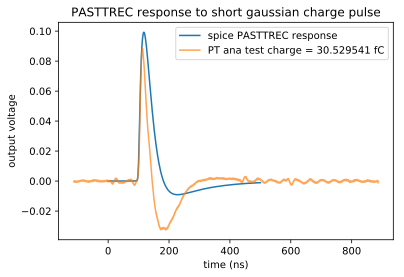

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/014.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/014.pickle


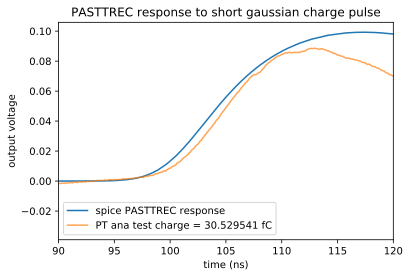

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/015.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/015.pickle


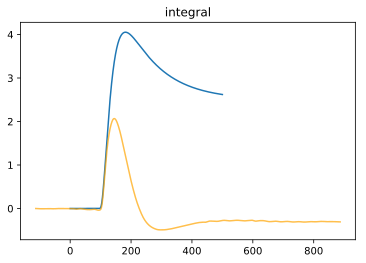

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/016.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/016.pickle


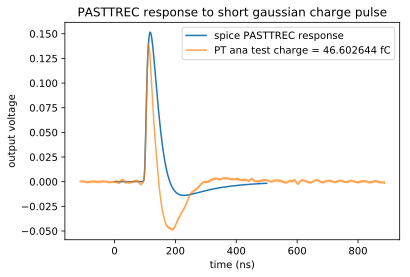

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/017.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/017.pickle


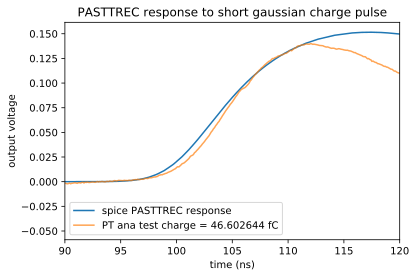

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/018.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/018.pickle


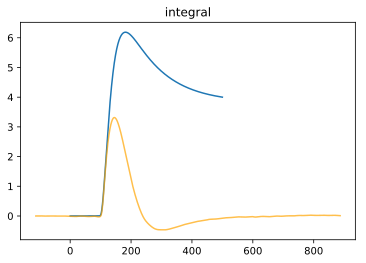

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/019.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/019.pickle


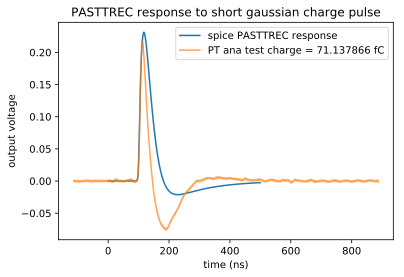

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/020.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/020.pickle


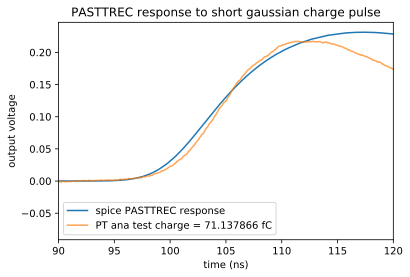

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/021.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/021.pickle


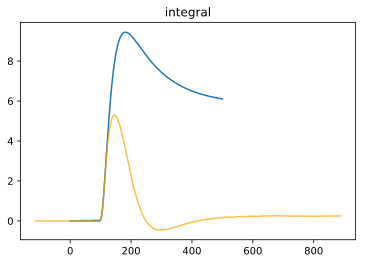

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/022.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/022.pickle


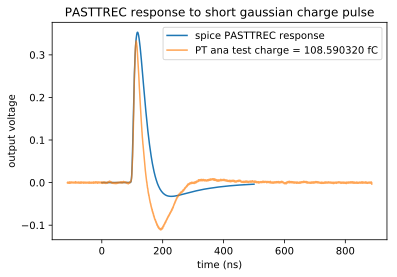

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/023.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/023.pickle


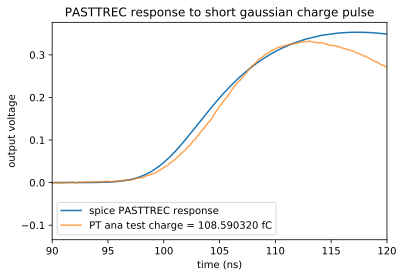

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/024.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/024.pickle


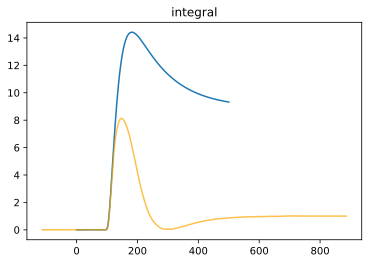

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/025.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/025.pickle


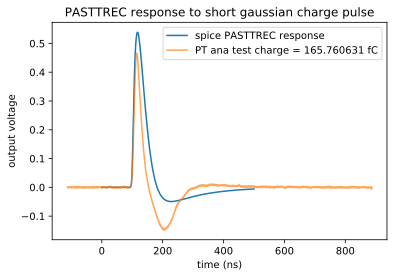

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/026.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/026.pickle


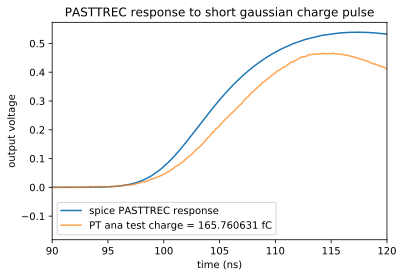

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/027.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/027.pickle


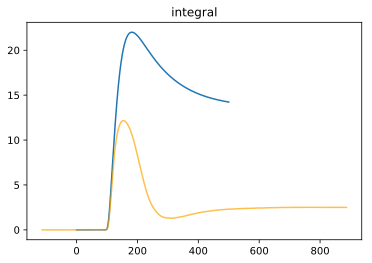

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/028.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/028.pickle


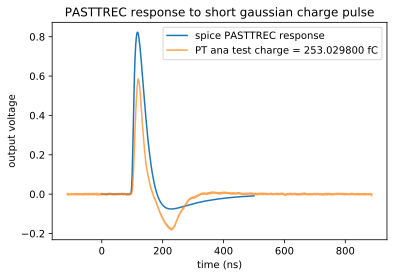

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/029.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/029.pickle


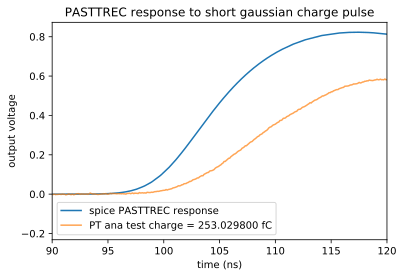

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/030.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/030.pickle


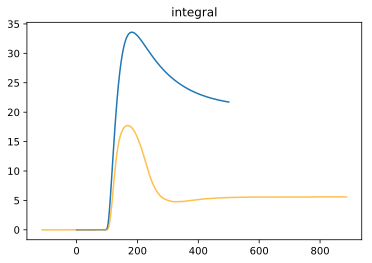

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/031.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/031.pickle


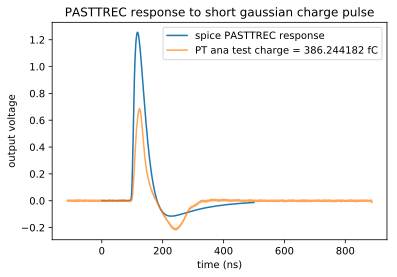

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/032.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/032.pickle


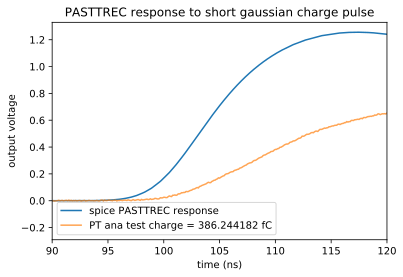

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/033.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/033.pickle


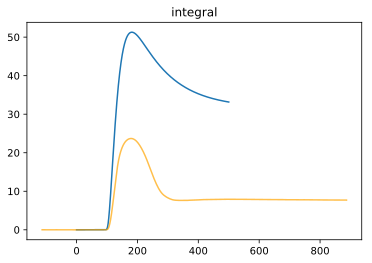

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/034.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/034.pickle


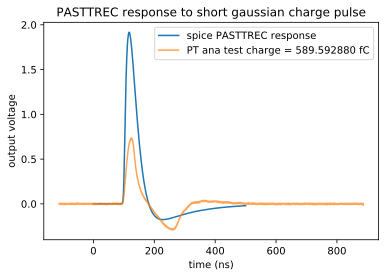

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/035.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/035.pickle


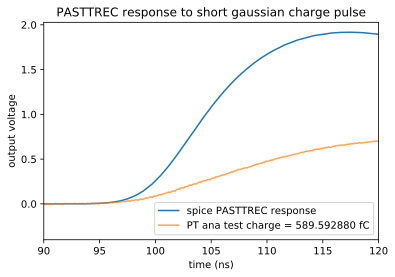

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/036.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/036.pickle


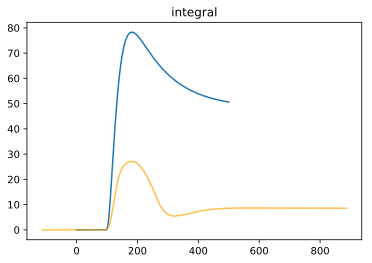

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/037.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/037.pickle


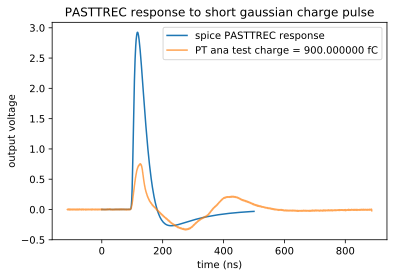

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/038.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/038.pickle


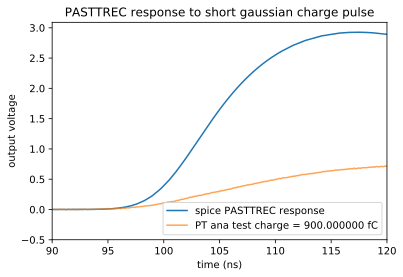

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/039.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/039.pickle


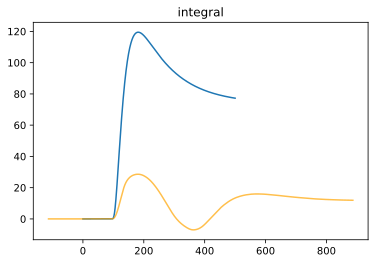

In [11]:
##################################################
##       compare charge classes to spice        ##
##################################################


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.rcParams["figure.figsize"] = (6,4)

ana_time_offset= -13

for i in range(0,len(ana_mem)):
  plt.plot(awg_time*1e9, -normalized_pt_vout*ana_mem[i]["charge"],label="spice PASTTREC response")
  plt.plot(np.array(ana_mem[i]["time"])*1e9+ana_time_offset,ana_mem[i]["voltage"],
           alpha=0.7,label="PT ana test charge = {:f} fC".format(ana_mem[i]["charge"]*1e15))
  plt.legend()
  plt.xlabel("time (ns)")
  plt.ylabel("output voltage")
  plt.title("PASTTREC response to short gaussian charge pulse")
  show(plt)

  plt.plot(awg_time*1e9, -normalized_pt_vout*ana_mem[i]["charge"],label="spice PASTTREC response")
  plt.plot(np.array(ana_mem[i]["time"])*1e9+ana_time_offset,ana_mem[i]["voltage"],
           alpha=0.7,label="PT ana test charge = {:f} fC".format(ana_mem[i]["charge"]*1e15))
  plt.legend()
  plt.xlabel("time (ns)")
  plt.ylabel("output voltage")
  plt.title("PASTTREC response to short gaussian charge pulse")
  plt.xlim(90,120)
  show(plt)


  plt.plot(awg_time*1e9, -integrate_dt(awg_time*1e9,normalized_pt_vout*ana_mem[i]["charge"]) ,label="spice PASTTREC response")
  plt.plot(np.array(ana_mem[i]["time"])*1e9+ana_time_offset,integrate_dt(np.array(ana_mem[i]["time"])*1e9+ana_time_offset,ana_mem[i]["voltage"]),"orange",alpha=0.7,label="real PASTTREC response")
  plt.title("integral")
  show(plt)

charge: 20.000000 fC, peaking time: 12.201220 ns
charge: 30.529541 fC, peaking time: 12.801280 ns
charge: 46.602644 fC, peaking time: 12.001200 ns
charge: 71.137866 fC, peaking time: 12.801280 ns
charge: 108.590320 fC, peaking time: 13.101310 ns
charge: 165.760631 fC, peaking time: 14.201420 ns
charge: 253.029800 fC, peaking time: 17.601760 ns
charge: 386.244182 fC, peaking time: 22.402240 ns
charge: 589.592880 fC, peaking time: 25.102511 ns
charge: 900.000000 fC, peaking time: 27.102711 ns
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/040.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/040.pickle


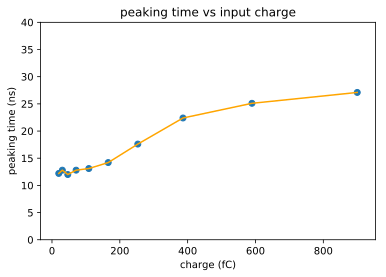

In [12]:
##################################################
##            determine peaking time            ##
##################################################

charge_list = []
peaking_time_list = []

for i in range(0,10):
  time = np.array(ana_mem[i]["time"])
  pt_ana  = np.array(ana_mem[i]["voltage"])
  charge  = ana_mem[i]["charge"]
  max_ampl = np.max(pt_ana)
  max_time = time[np.argmax(pt_ana)]
    
  ten_percent_time = time[ np.nonzero(pt_ana > 0.1*max_ampl)[0][0]  ]

  peaking_time = max_time-ten_percent_time
    
  print("charge: {:f} fC, peaking time: {:f} ns".format(charge*1e15,peaking_time*1e9))

  charge_list += [charge]
  peaking_time_list += [peaking_time]
           #label="test charge = {:f} fC".format(ana_mem[i]["charge"]*1e15))
    
plt.plot(
  np.array(charge_list)*1e15,
  np.array(peaking_time_list)*1e9,
  "orange",
  label="peaking time vs input charge"
)
plt.scatter(
  np.array(charge_list)*1e15,
  np.array(peaking_time_list)*1e9,
  label="peaking time vs input charge"
)

plt.xlabel("charge (fC)")
plt.ylabel("peaking time (ns)")
plt.title("peaking time vs input charge")
plt.ylim(0,40)
show(plt)

In [13]:
##################################################
##        systematic tot vs charge scan         ##
##################################################


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.rcParams["figure.figsize"] = (11,6)


start_charge = 15e-15
stop_charge  = 900e-15

n= (fine==True)*40 +(fine==False)*10
steps= (fine==True)*50 + (fine==False)*10

ptc.set_threshold("0001",1,0,16) # tdc, conn, chip thresh


t1_list = []
tot_list = []
t1_std_list = []
tot_std_list = []
charge_list = []


for log_test_charge in np.linspace(np.log(start_charge),np.log(stop_charge),steps):

  test_charge = np.exp(log_test_charge)

  test_i = - test_charge * gauss(awg_time,mu=100e-9,sigma=2.5e-9)

  test_curr = np.max(abs(test_i))
  test_amp  = test_curr * injection_resistor

  y1 = test_i * injection_resistor

  print("test charge       = {:f} fC".format(test_charge*1e15))
  print("max(test current) = {:f} uA".format(test_curr*1e6))
  print("test amplitude    = {:f} V".format(test_amp))

  rigol.set_waveform(1, awg_time, y1, v_range=5 )

  vals = lecroy.measure_statistics([m["PASTTREC_t1"],m["PASTTREC_tot"]],n)

  charge_list += [test_charge]
  t1_list     += [np.mean(vals[m["PASTTREC_t1"]])]
  tot_list    += [np.mean(vals[m["PASTTREC_tot"]])]
  t1_std_list     += [np.std(vals[m["PASTTREC_t1"]])]
  tot_std_list    += [np.std(vals[m["PASTTREC_tot"]])]

  
pickle_this(t1_list,"t1_list")
pickle_this(tot_list,"tot_list")
pickle_this(t1_std_list,"t1_std_list")
pickle_this(tot_std_list,"tot_std_list")
pickle_this(charge_list,"charge_list")

test charge       = 15.000000 fC
max(test current) = 2.393654 uA
test amplitude    = 0.078512 V
test charge       = 16.307225 fC
max(test current) = 2.602257 uA
test amplitude    = 0.085354 V
test charge       = 17.728372 fC
max(test current) = 2.829039 uA
test amplitude    = 0.092792 V
test charge       = 19.273370 fC
max(test current) = 3.075585 uA
test amplitude    = 0.100879 V
test charge       = 20.953012 fC
max(test current) = 3.343617 uA
test amplitude    = 0.109671 V
test charge       = 22.779032 fC
max(test current) = 3.635008 uA
test amplitude    = 0.119228 V
test charge       = 24.764186 fC
max(test current) = 3.951792 uA
test amplitude    = 0.129619 V
test charge       = 26.922344 fC
max(test current) = 4.296184 uA
test amplitude    = 0.140915 V
test charge       = 29.268581 fC
max(test current) = 4.670590 uA
test amplitude    = 0.153195 V
test charge       = 31.819289 fC
max(test current) = 5.077624 uA
test amplitude    = 0.166546 V
test charge       = 34.592287 fC
max(tes

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/041.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/041.pickle


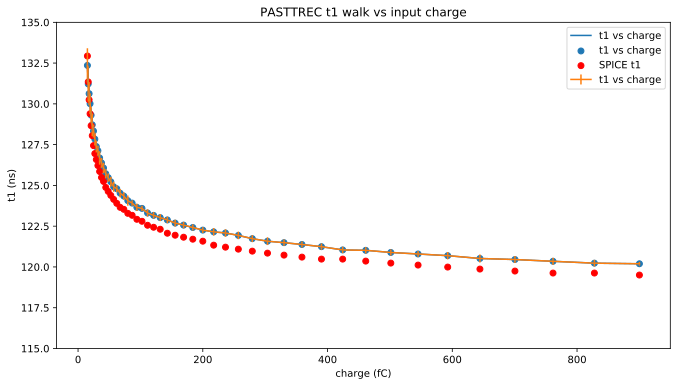

saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/042.svg
saving to /workdir/jupyter/PASTTREC/PASTTREC_IR_real_vs_spice-Trafo_data/042.pickle


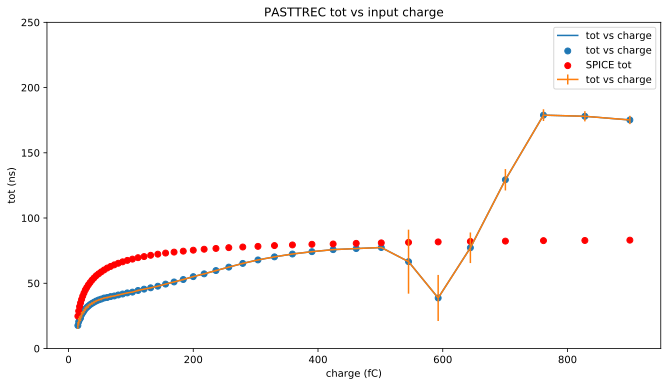

In [14]:

soft_t1_list = []
soft_tot_list = []

spice_vert_offset = 22.8

for log_test_charge in np.linspace(np.log(start_charge),np.log(stop_charge),steps):

  test_charge = np.exp(log_test_charge)
  soft_discr_out, soft_t1, soft_tot = discriminate( awg_time, -normalized_pt_vout*test_charge, 30e-3,8.4e-3,4.2e-3)
  soft_t1_list +=   [soft_t1]
  soft_tot_list +=  [soft_tot]
plt.plot(1e15*np.array(charge_list),1e9*np.array(t1_list), label="t1 vs charge")
plt.scatter(1e15*np.array(charge_list),1e9*np.array(t1_list), label="t1 vs charge")
plt.errorbar(1e15*np.array(charge_list),1e9*np.array(t1_list),yerr=1e9*np.array(t1_std_list), label="t1 vs charge")

plt.scatter(1e15*np.array(charge_list),1e9*np.array(soft_t1_list)+spice_vert_offset, color="red",label="SPICE t1 ")
plt.xlabel("charge (fC)")
plt.ylabel("t1 (ns)")
plt.legend()
plt.title("PASTTREC t1 walk vs input charge")
plt.ylim(115,135)
show(plt)

plt.plot(1e15*np.array(charge_list),1e9*np.array(tot_list), label="tot vs charge")
plt.scatter(1e15*np.array(charge_list),1e9*np.array(tot_list), label="tot vs charge")
plt.errorbar(1e15*np.array(charge_list),1e9*np.array(tot_list),yerr=1e9*np.array(tot_std_list), label="tot vs charge")
plt.scatter(1e15*np.array(charge_list),1e9*np.array(soft_tot_list), color="red", label="SPICE tot ")
plt.xlabel("charge (fC)")
plt.ylabel("tot (ns)")
plt.title("PASTTREC tot vs input charge")
plt.ylim(0,250)
plt.legend()
show(plt)
